## Rainforest Audio Sample Classification

This is a for the [Kaggle competition](https://www.kaggle.com/c/rfcx-species-audio-detection/overview). I will convert these audio samples to images in the frequency domain and use fastai to classify them. The targets are the probability that each species is in the audio file.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import librosa
import librosa.display
import matplotlib as plt
import numpy as np
import pandas as pd

from IPython.display import Audio

from fastai.data.all import *
from fastai.vision.all import *
from sklearn.metrics import label_ranking_average_precision_score

from scipy.fftpack import fft
from scipy.signal import get_window

In [3]:
dpath = Path('rfcx-species-audio-detection/')
tp_df = pd.read_csv(dpath/'train_tp.csv')
tp_df.head()

recording_id  species_id  songtype_id    t_min     f_min    t_max     f_max
0    003bec244          14            1  44.5440  2531.250  45.1307   5531.25
1    006ab765f          23            1  39.9615  7235.160  46.0452  11283.40
2    007f87ba2          12            1  39.1360   562.500  42.2720   3281.25
3    0099c367b          17            4  51.4206  1464.260  55.1996   4565.04
4    009b760e6          10            1  50.0854   947.461  52.5293  10852.70

In [4]:
fp_df = pd.read_csv(dpath/'train_fp.csv')
fp_df.head()

recording_id  species_id  songtype_id    t_min       f_min    t_max  \
0    00204008d          21            1  13.8400   3281.2500  14.9333   
1    00204008d           8            1  24.4960   3750.0000  28.6187   
2    00204008d           4            1  15.0027   2343.7500  16.8587   
3    003b04435          22            1  43.2533  10687.5000  44.8587   
4    003b04435          23            1   9.1254   7235.1562  15.2091   

        f_max  
0   4125.0000  
1   5531.2500  
2   4218.7500  
3  13687.5000  
4  11283.3984

### Creating labels from the train csv files

In [5]:
nspecies = tp_df['species_id'].max() 
for i in range(nspecies+1):
    tp_df[f"s{i}"] = [1 if x == i else 0 for x in tp_df['species_id']]
    
tp_df.head()

recording_id  species_id  songtype_id    t_min     f_min    t_max     f_max  \
0    003bec244          14            1  44.5440  2531.250  45.1307   5531.25   
1    006ab765f          23            1  39.9615  7235.160  46.0452  11283.40   
2    007f87ba2          12            1  39.1360   562.500  42.2720   3281.25   
3    0099c367b          17            4  51.4206  1464.260  55.1996   4565.04   
4    009b760e6          10            1  50.0854   947.461  52.5293  10852.70   

   s0  s1  s2  ...  s14  s15  s16  s17  s18  s19  s20  s21  s22  s23  
0   0   0   0  ...    1    0    0    0    0    0    0    0    0    0  
1   0   0   0  ...    0    0    0    0    0    0    0    0    0    1  
2   0   0   0  ...    0    0    0    0    0    0    0    0    0    0  
3   0   0   0  ...    0    0    0    1    0    0    0    0    0    0  
4   0   0   0  ...    0    0    0    0    0    0    0    0    0    0  

[5 rows x 31 columns]

In [6]:
for i in range(nspecies+1):
    fp_df[f"s{i}"] = [1 if x == i else 0 for x in fp_df['species_id']]
    
fp_df.head()

recording_id  species_id  songtype_id    t_min       f_min    t_max  \
0    00204008d          21            1  13.8400   3281.2500  14.9333   
1    00204008d           8            1  24.4960   3750.0000  28.6187   
2    00204008d           4            1  15.0027   2343.7500  16.8587   
3    003b04435          22            1  43.2533  10687.5000  44.8587   
4    003b04435          23            1   9.1254   7235.1562  15.2091   

        f_max  s0  s1  s2  ...  s14  s15  s16  s17  s18  s19  s20  s21  s22  \
0   4125.0000   0   0   0  ...    0    0    0    0    0    0    0    1    0   
1   5531.2500   0   0   0  ...    0    0    0    0    0    0    0    0    0   
2   4218.7500   0   0   0  ...    0    0    0    0    0    0    0    0    0   
3  13687.5000   0   0   0  ...    0    0    0    0    0    0    0    0    1   
4  11283.3984   0   0   0  ...    0    0    0    0    0    0    0    0    0   

   s23  
0    0  
1    0  
2    0  
3    0  
4    1  

[5 rows x 31 columns]

In [7]:
tp_labels = tp_df.drop(['species_id', 'songtype_id', 't_min', 'f_min', 't_max', 'f_max'], axis=1)
fp_labels = fp_df.drop(['species_id', 'songtype_id', 't_min', 'f_min', 't_max', 'f_max'], axis=1)
tp_labels.head()

recording_id  s0  s1  s2  s3  s4  s5  s6  s7  s8  ...  s14  s15  s16  s17  \
0    003bec244   0   0   0   0   0   0   0   0   0  ...    1    0    0    0   
1    006ab765f   0   0   0   0   0   0   0   0   0  ...    0    0    0    0   
2    007f87ba2   0   0   0   0   0   0   0   0   0  ...    0    0    0    0   
3    0099c367b   0   0   0   0   0   0   0   0   0  ...    0    0    0    1   
4    009b760e6   0   0   0   0   0   0   0   0   0  ...    0    0    0    0   

   s18  s19  s20  s21  s22  s23  
0    0    0    0    0    0    0  
1    0    0    0    0    0    1  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 25 columns]

### Converting Audio Files to Frequency Domain

In [8]:
train_path = dpath/'train'
clip, sample_rate = librosa.load(train_path.ls()[0])
print('Sample Rate   {} Hz'.format(sample_rate))
print('Clip Length   {:3.2f} seconds'.format(len(clip)/sample_rate))

Sample Rate   22050 Hz
Clip Length   60.00 seconds


In [9]:
Audio(clip, rate=sample_rate)

In [10]:
rel_clip = clip[int(sample_rate * tp_df.loc[0, 't_min']):int(sample_rate * tp_df.loc[0, 't_max'])]
Audio(rel_clip, rate=sample_rate)

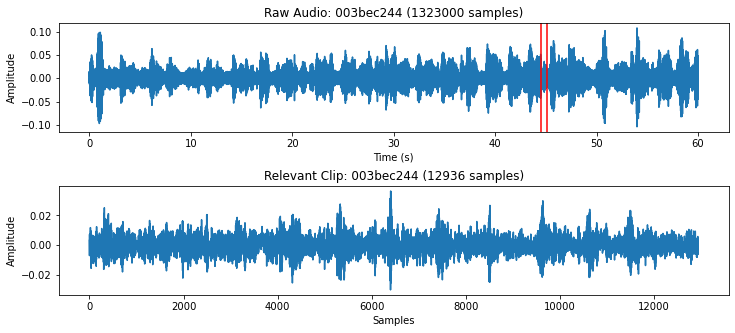

In [11]:
timesteps = np.arange(len(clip)) / sample_rate
fig, ax = plt.subplots(2, figsize=(12, 5))
fig.subplots_adjust(hspace=0.5)

# plot the entire clip 
ax[0].plot(timesteps, clip)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Raw Audio: {} ({} samples)'.format(tp_df.loc[0, 'recording_id'], len(clip)))


n_fft = 1024 # frame length 

# mark location of frame in the entire signal
ax[0].axvline(tp_df.loc[0, 't_min'], c='r') 
ax[0].axvline(tp_df.loc[0, 't_max'], c='r')

# plot N samples 
ax[1].plot(rel_clip)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Relevant Clip: {} ({} samples)'.format(tp_df.loc[0, 'recording_id'], len(rel_clip)));

In [12]:
n_fft = 1024
X = fft(clip, n_fft)
X.shape, X.dtype

((1024,), dtype('complex64'))

((513,), dtype('float32'))

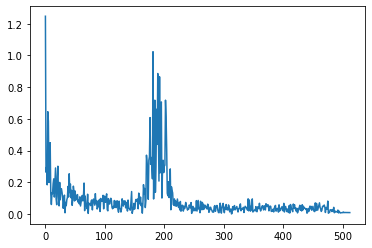

In [13]:
X = X[:n_fft//2+1]

# Convert from rectangular to polar, usually only care about magnitude
X_magnitude, X_phase = librosa.magphase(X)

plt.plot(X_magnitude);

X_magnitude.shape, X_magnitude.dtype

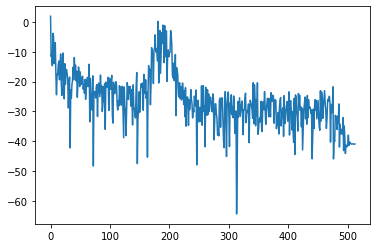

In [14]:
X_magnitude_db = librosa.amplitude_to_db(X_magnitude)

plt.plot(X_magnitude_db);

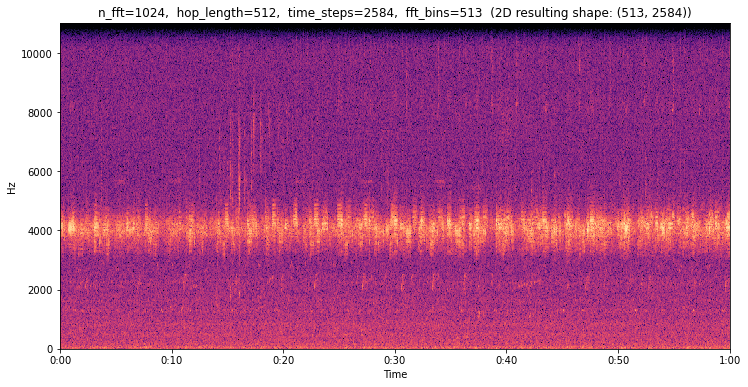

In [15]:
hop_length = 512
stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_magnitude_db, x_axis='time', y_axis='linear', 
                         sr=sample_rate, hop_length=hop_length)

title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(n_fft, hop_length, 
                       stft_magnitude_db.shape[1], 
                       stft_magnitude_db.shape[0], 
                       stft_magnitude_db.shape));

C:\Users\arnav\Anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\arnav\Anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


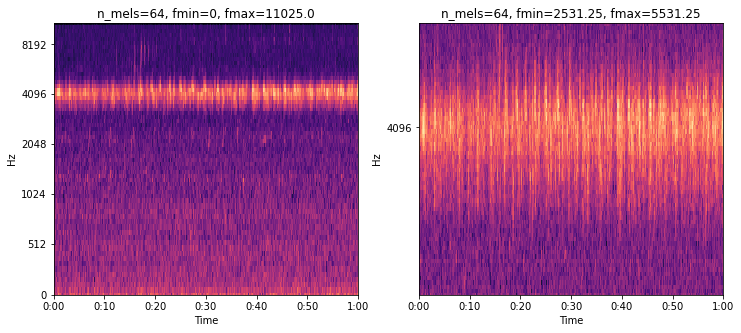

In [16]:
# number of mel frequency bands 
n_mels = 64

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

fmin = 0            
fmax = sample_rate/2
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[0])
ax[0].set_title(f'n_mels=64, fmin={fmin}, fmax={fmax}')

fmin = tp_df.loc[0,'f_min']           
fmax = tp_df.loc[0, 'f_max']
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0, 
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[1])
ax[1].set_title(f'n_mels=64, fmin={fmin}, fmax={fmax}')

plt.show()

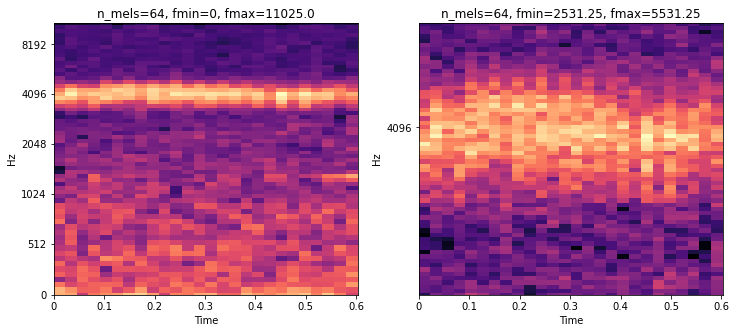

In [17]:
n_mels = 64
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

fmin = 0            
fmax = sample_rate/2
mel_spec = librosa.feature.melspectrogram(rel_clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[0])
ax[0].set_title(f'n_mels={n_mels}, fmin={fmin}, fmax={fmax}')

fmin = tp_df.loc[0,'f_min']           
fmax = tp_df.loc[0, 'f_max']
mel_spec = librosa.feature.melspectrogram(rel_clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0, 
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[1])
ax[1].set_title(f'n_mels={n_mels}, fmin={fmin}, fmax={fmax}')

plt.show()

In [18]:
fname = dpath/'train_spectrogram'/'rel_clip'/f"{tp_df.loc[0,'recording_id']}.png"
with open(dpath/'hello.png', 'w') as f: pass
fig = plt.figure(figsize=[0.72,0.72])
ax = fig.add_subplot(111)
plt.axis('off')
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax)
plt.savefig(dpath/'hello.png', dpi=400,bbox_inches='tight',pad_inches=0)
plt.close('all')

In [19]:
def flac2png(rec_id, fname, fmin=0, fmax=None, tmin=None, tmax=None):
    # given the recording_id, fmin, and fmax, returns melspectograph of clip as a png
    clip, sample_rate = librosa.load(dpath/'train'/f'{rec_id}.flac')
    if fmax == None:
        fmax = sample_rate / 2
    else:
        clip = clip[int(sample_rate * tmin):int(sample_rate * tmax)]
    n_fft = 1024
    hop_length = 512
    n_mels = 64
    
    mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    plt.axis('off')
    librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax)
    plt.savefig(fname, dpi=400, bbox_inches='tight', pad_inches=0)
    plt.close('all')

C:\Users\arnav\Anaconda3\envs\fastai2\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


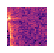

In [21]:
from tqdm.notebook import tnrange
import os

try:
    os.mkdir(dpath/'train_spectrogram')
    os.mkdir(dpath/'train_spectrogram'/'full_clip')
    os.mkdir(dpath/'train_spectrogram'/'rel_clip')

except FileExistsError:
    pass
    
for i in tnrange(len(tp_df)):
    fname = dpath/'train_spectrogram'/'full_clip'/f"{tp_df.loc[i, 'recording_id']}.png"
    with open(fname, 'w') as fp: pass
    flac2png(tp_df.loc[i, 'recording_id'], fname)
    
    fname = dpath/'train_spectrogram'/'rel_clip'/f"{tp_df.loc[i, 'recording_id']}.png"
    with open(fname, 'w') as fp: pass
    flac2png(tp_df.loc[i, 'recording_id'], fname, 
             tp_df.loc[i, 'f_min'], tp_df.loc[i, 'f_max'], 
             tp_df.loc[0, 't_min'], tp_df.loc[0, 't_max'])

## Creating the model

In [20]:
#tp_df.set_index('recording_id', inplace=True)
#def label_func(fname):
#    return f"s{tp_df.loc[fnames[0].name[:-4], 'species_id']}"
tp_df['species_id'] = 's' + tp_df['species_id'].astype('string')
df_full_tp = tp_df.drop(['t_min', 't_max', 'f_min', 'f_max', 'songtype_id'], axis=1)
df_full_tp['species_id'] = df_full_tp.groupby('recording_id')['species_id'].transform(",".join)

In [20]:
# dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
#                    splitter = RandomSplitter(valid_pct=0.2, seed=42),
#                    get_x = lambda x:dpath/"train_spectrogram"/"full_clip"/f'{x[0]}.png',
#                    get_y = ColReader(1, label_delim=','))
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter = RandomSplitter(valid_pct=0.2, seed=42),
                   get_x = lambda x:dpath/"train_spectrogram"/"rel_clip"/f'{x[0]}.png',
                   get_y = ColReader(1, label_delim=','))
dsets = dblock.datasets(tp_df)
dsets.train[0]

(PILImage mode=RGB size=223x217,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]))

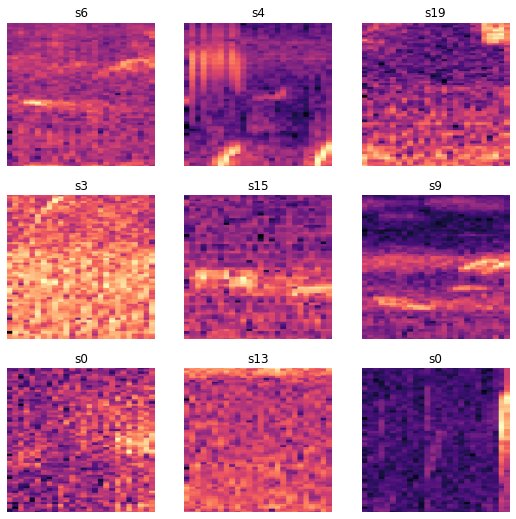

In [21]:
dls = dblock.dataloaders(tp_df, bs=16, num_workers=0)
dls.show_batch()

In [22]:
# learn = Learner(dls, xresnet50(n_out=24), metrics=accuracy_multi)
# learn = Learner(dls, resnet34, metrics=accuracy_multi)
learn = cnn_learner(dls, resnet18, metrics=[accuracy_multi])

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.04786301031708717)

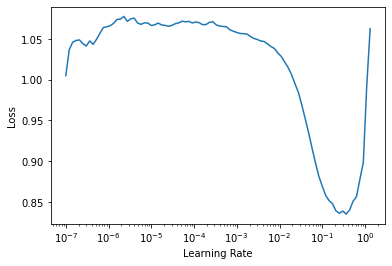

In [28]:
learn.lr_find()

In [29]:
learn.fit_one_cycle(5,5e-2)

In [30]:
learn.save('stage-18-5')

Path('models/stage-18-5.pth')

In [23]:
learn.load('stage-18-5')
learn.unfreeze()
learn.lr_find()

In [24]:
learn.fine_tune(1, base_lr=4e-5)

In [25]:
learn.save('stage-18-1')

Path('models/stage-18-1.pth')

### Transfer Learning

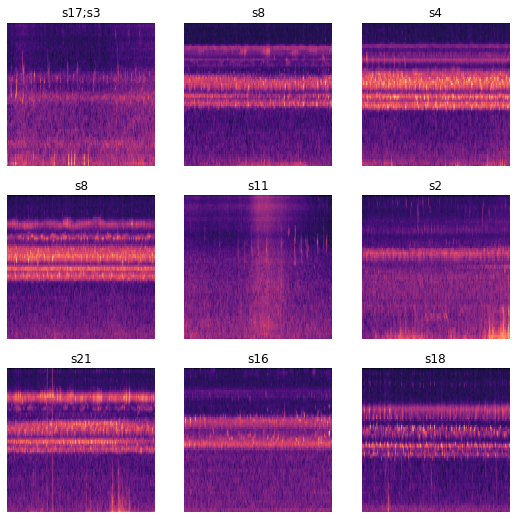

In [21]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter = RandomSplitter(valid_pct=0.2, seed=42),
                   get_x = lambda x:dpath/"train_spectrogram"/"full_clip"/f'{x[0]}.png',
                   get_y = ColReader(1, label_delim=','))
# dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
#                    splitter = RandomSplitter(valid_pct=0.2, seed=42),
#                    get_x = lambda x:dpath/"train_spectrogram"/"rel_clip"/f'{x[0]}.png',
#                    get_y = ColReader(1, label_delim=','))

dls = dblock.dataloaders(df_full_tp, bs=16, num_workers=0)
dls.show_batch()

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=2.75422871709452e-06)

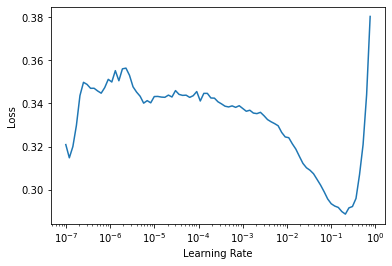

In [22]:
# learn = Learner(dls, xresnet50(n_out=24), metrics=accuracy_multi)
learn = cnn_learner(dls, resnet18, metrics=[accuracy_multi])
learn.load('stage-18-1')
learn.lr_find()

In [23]:
learn.fit_one_cycle(4, 2e-3)

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=1.5848931980144698e-06)

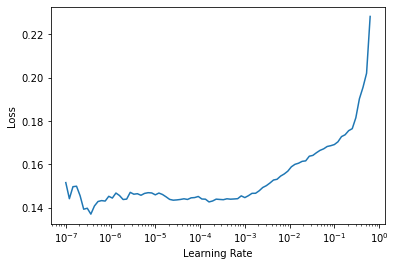

In [24]:
learn.save('stage-19-4')
learn.unfreeze()
learn.lr_find()

In [25]:
learn.fine_tune(2, base_lr=2e-6)

In [54]:
def flac2png(rec_id, fname, fmin=0, fmax=None, tmin=None, tmax=None):
    # given the recording_id, fmin, and fmax, returns melspectograph of clip as a png
    clip, sample_rate = librosa.load(dpath/'test'/f'{rec_id}.flac')
    if fmax == None:
        fmax = sample_rate / 2
    else:
        clip = clip[int(sample_rate * tmin):int(sample_rate * tmax)]
    n_fft = 1024
    hop_length = 512
    n_mels = 64
    
    mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    plt.axis('off')
    librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax)
    plt.savefig(fname, dpi=400, bbox_inches='tight', pad_inches=0)
    plt.close('all')

In [57]:
from tqdm.notebook import tnrange
import os

try:
    os.mkdir(dpath/'test_spectrogram')

except FileExistsError:
    pass

sample = pd.read_csv(dpath/'sample_submission.csv')    
for i in tnrange(len(sample)):
    fname = dpath/'test_spectrogram'/f"{sample.loc[i, 'recording_id']}.png"
    with open(fname, 'w') as fp: pass
    flac2png(sample.loc[i, 'recording_id'], fname)

In [26]:
sample = pd.read_csv(dpath/'sample_submission.csv')
test_files = [dpath/'test_spectrogram'/f'{id}.png' for id in sample.recording_id]
#for r in tnrange(len(sample)):
  #  fname = dpath/'test_spectrogram'/f"{sample.loc[i, 'recording_id']}.png"
   # learn.predict

test_dl = dls.test_dl(test_files)
preds,_ = learn.get_preds(dl=test_dl)

submission = pd.concat([sample['recording_id'], pd.DataFrame(preds.numpy(), columns=sample.columns[1:])], axis=1)
submission

recording_id        s0        s1        s2        s3        s4        s5  \
0       000316da7  0.006684  0.013527  0.007230  0.027713  0.007368  0.001565   
1       003bc2cb2  0.013652  0.040384  0.000533  0.001646  0.001611  0.014548   
2       0061c037e  0.002261  0.001123  0.008337  0.025064  0.000039  0.000839   
3       010eb14d3  0.099787  0.072972  0.000002  0.000139  0.254566  0.033549   
4       011318064  0.009692  0.012919  0.006493  0.027927  0.002884  0.001769   
...           ...       ...       ...       ...       ...       ...       ...   
1987    ff68f3ac3  0.020097  0.010789  0.000178  0.003378  0.040487  0.019841   
1988    ff973e852  0.002368  0.007039  0.075250  0.254295  0.002748  0.000392   
1989    ffa5cf6d6  0.000059  0.000134  0.006414  0.005242  0.002696  0.005916   
1990    ffa88cbb8  0.012793  0.053082  0.000259  0.000621  0.017275  0.027261   
1991    ffda5d7b3  0.026918  0.021841  0.000891  0.023165  0.033602  0.004544   

            s6        s7        s8  ...       s14       s15       s16  \
0     0.021468  0.037506  0.006741  ...  0.003400  0.013109  0.095431   
1     0.003189  0.011496  0.689827  ...  0.012707  0.014315  0.028367   
2     0.001434  0.000986  0.004280  ...  0.028858  0.066054  0.013938   
3     0.019863  0.000105  0.001105  ...  0.007728  0.005330  0.001862   
4     0.015841  0.070230  0.022903  ...  0.004110  0.019297  0.016943   
...        ...       ...       ...  ...       ...       ...       ...   
1987  0.015926  0.037495  0.005715  ...  0.002759  0.002161  0.464211   
1988  0.005006  0.016100  0.009015  ...  0.005436  0.100273  0.026194   
1989  0.000259  0.034140  0.007909  ...  0.000407  0.018620  0.029410   
1990  0.027579  0.035589  0.180118  ...  0.001193  0.002552  0.050542   
1991  0.035860  0.021658  0.014612  ...  0.004253  0.008894  0.101559   

           s17       s18       s19       s20       s21       s22       s23  
0     0.039092  0.004967  0.047450  0.032268  0.006659  0.005804  0.055150  
1     0.013206  0.000483  0.008952  0.002530  0.006259  0.003872  0.004492  
2     0.001324  0.012734  0.001789  0.016828  0.013447  0.002434  0.002986  
3     0.003127  0.009106  0.000275  0.000043  0.000533  0.044296  0.002312  
4     0.016591  0.000553  0.019161  0.031209  0.043956  0.004939  0.060106  
...        ...       ...       ...       ...       ...       ...       ...  
1987  0.649841  0.004733  0.007881  0.004488  0.013729  0.002575  0.010980  
1988  0.013011  0.001251  0.036991  0.052353  0.084546  0.006263  0.030029  
1989  0.021759  0.000511  0.101200  0.118683  0.001150  0.000165  0.064611  
1990  0.271871  0.001394  0.018294  0.000950  0.063268  0.003276  0.010110  
1991  0.107746  0.005689  0.061509  0.014309  0.173840  0.014864  0.011638  

[1992 rows x 25 columns]

In [27]:
submission.to_csv('submission.csv', index=False)

In [72]:
skm_to_fastai()

24

In [76]:
pd.DataFrame(preds.numpy())

0
0   0.001992
1   0.005411
2   0.163278
3   0.380134
4   0.023409
5   0.001410
6   0.024506
7   0.001047
8   0.003245
9   0.293905
10  0.007797
11  0.009748
12  0.004032
13  0.318355
14  0.001799
15  0.006266
16  0.006709
17  0.002974
18  0.026334
19  0.043905
20  0.103354
21  0.002920
22  0.001120